## Introduction

Credit scoring dùng để  tham khảo cho việc xét duyệt trước khi cho vay. Nhiệm vụ đặt ra xây dựng thuật toán ML phân loại hai nhóm khách hàng này.

## Description data

- loan_status: Trạng thái khoản vay (Bad nếu *Charged Off* hoặc *Default*,  Good nếu *Fully Paid*)  
- loan_amnt:   Tổng số tiền của khoản vay  
- int_rate: Lãi suất khoản vay  
- grade: Hạng công việc  
- emp_length: Thời gian làm việc  
- home_ownership: Loại hình sở hữu nhà  
- annual_inc: Tổng thu nhập hằng năm  
- term: Kì hạn vay

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
display(train_df.head())

,loan_status,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc,term
0,Fully Paid,6000.0,9.76,B,4 years,RENT,33000.0,36 months
1,Fully Paid,19700.0,6.62,A,5 years,RENT,45000.0,36 months
2,Fully Paid,14000.0,6.03,A,< 1 year,MORTGAGE,75000.0,36 months
3,Fully Paid,21000.0,13.11,B,2 years,RENT,51000.0,36 months
4,Charged Off,4500.0,16.29,D,2 years,MORTGAGE,96000.0,36 months


In [4]:
display(test_df.head())

,loan_status,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc,term
0,Fully Paid,9525.0,6.62,A,2 years,RENT,60000.0,36 months
1,Charged Off,17325.0,11.14,B,1 year,MORTGAGE,54000.0,36 months
2,Fully Paid,7000.0,8.49,A,5 years,RENT,118000.0,36 months
3,Fully Paid,10000.0,16.24,C,10+ years,MORTGAGE,150000.0,60 months
4,Fully Paid,9600.0,12.12,B,8 years,RENT,120000.0,36 months


## Evaluation

Đánh giá hiệu suất model dựa trên hệ số [Gini](https://en.wikipedia.org/wiki/Gini_coefficient)

# Phân tích đánh giá dữ liệu

In [5]:
print('Training data shape: ', train_df.shape)
print('Testing data shape: ', test_df.shape)

Training data shape:  (177933, 8)
Testing data shape:  (76257, 8)


Tập dữ liệu huấn luyện có 177933 hàng tương ứng là số  khoản vay và 8 cột thuộc tính, bao gồm **loan_status** là kết quả cần dự đoán. Tập test có 76257 bản ghi với các thuộc tính tương tự.

Tiến hành kiể m tra tương quan phân phối kết quả (nhãn **loan_status**) ở 2 tập dữ liệu.

In [6]:
train_df.loan_status.value_counts() / len(train_df)

Fully Paid     0.817347
Charged Off    0.177887
Default        0.004766
Name: loan_status, dtype: float64

In [7]:
test_df.loan_status.value_counts() / len(test_df)

Fully Paid     0.816843
Charged Off    0.178292
Default        0.004865
Name: loan_status, dtype: float64

Có thể nhận thấy kết quả ở hai tập là tương đương với nhau. Trong đó, tỉ lệ khách hàng tốt đều chiếm khoảng 81,7%, vượt trội so với tỉ lệ khách hàng xấu.
Ta sẽ tạo thêm một feature **target** với giá trị 0 đại diện cho giá trị **Fully Paid** và 1 tương ứng với **Default* hoặc **Charged Off**

In [8]:
train = train_df.copy()
test = test_df.copy()

train['target'] = np.where(train.loan_status == 'Fully Paid', 0, 1)
test['target'] = np.where(test.loan_status == 'Fully Paid', 0, 1)

train.drop(columns='loan_status', inplace=True)
test.drop(columns='loan_status', inplace=True)

In [9]:
train.head()

,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc,term,target
0,6000.0,9.76,B,4 years,RENT,33000.0,36 months,0
1,19700.0,6.62,A,5 years,RENT,45000.0,36 months,0
2,14000.0,6.03,A,< 1 year,MORTGAGE,75000.0,36 months,0
3,21000.0,13.11,B,2 years,RENT,51000.0,36 months,0
4,4500.0,16.29,D,2 years,MORTGAGE,96000.0,36 months,1


### Kiểm tra Missing values

In [10]:
train.isnull().sum()

loan_amnt            0
int_rate             0
grade                0
emp_length        7013
home_ownership       0
annual_inc           0
term                 0
target               0
dtype: int64

Trong các thuộc tính, chỉ có **emp_length** có missing value.
Đây là thuộc tính thể hiện thời gian (kinh nghiệm) làm việc của người đi vay.
<!-- Ta sẽ thay thế các giá trị null bằng giá trị *Mode*. -->
Việc xử  lý mising value sẽ được đề cập ở phần dưới khi xử lý các thuộc tính rời rạc.

#### Về kiểu dữ liệu của các thuộc tính

In [11]:
train.describe()

,loan_amnt,int_rate,annual_inc,target
count,177933.000000,177933.000000,1.779330e+05,177933.000000
mean,13582.523337,13.788521,7.245937e+04,0.182653
std,8138.463931,4.403421,5.596903e+04,0.386383
min,500.000000,5.320000,3.000000e+03,0.000000
25%,7300.000000,10.740000,4.500000e+04,0.000000
50%,12000.000000,13.570000,6.200000e+04,0.000000
75%,18375.000000,16.590000,8.700000e+04,0.000000
max,35000.000000,28.990000,7.141778e+06,1.000000


Ngoài **target**, có ba thuộc tính nhận giá trị liên tục là **loan_amt**, **int_rate** và **annual_inc**. Bốn thuộc tính còn lại nhận giá trị rời rạc.
Bây giờ ta sẽ kiể m tra mối liên hệ giữa các thuộc tính đến kết quả khách hàng có khả năng thanh toán khoản vay hay không. Đối với các thuộc tính có giá trị số liên tục, sử dụng phân phối boxplot để biểu diễn.

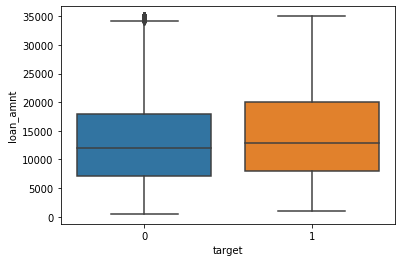

In [12]:
# boxplot for loan amount
sns.boxplot(train.target, train.loan_amnt)

Qua biểu đồ, có thể thấy, những khoản nợ xấu thường có giá trị lớn hơn nợ tốt. Tuy nhiên sự chênh lệch là không nhiều.

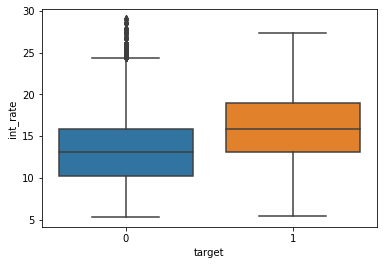

In [13]:
# boxplot for int rate
sns.boxplot(train.target, train.int_rate)

Ở biểu đồ của lãi suất, đã có sự chênh lệch rõ ràng hơn. Có thể thấy việc vay lãi suất cao sẽ dẫn tới việc trả nợ khó khăn hơn.

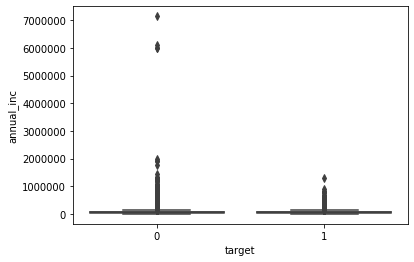

In [14]:
# boxplot for annual income
sns.boxplot(train.target, train.annual_inc)

Có thể thấy thu nhập của khách hàng có phân phối không chuẩn, có nhiều ngoại lệ (Outlier) với thu nhập cao hơn hẳn so với phần còn lại. Đây là những  ngoại lệ hợp lý khi đi đi cùng với thu nhập cao này là khả năng có thể trả nợ.
Để  khắc phục điều này, áp dụng *Log transform* sẽ giúp mở rộng các giá trị nằm trong phạm vi mật độ thấp và né hoặc giảm các giá trị trong phạm vi mật độ cao.

,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc,term,target,annual_inc_log
0,6000.0,9.76,B,4 years,RENT,33000.0,36 months,0,10.404293
1,19700.0,6.62,A,5 years,RENT,45000.0,36 months,0,10.714440
2,14000.0,6.03,A,< 1 year,MORTGAGE,75000.0,36 months,0,11.225257
3,21000.0,13.11,B,2 years,RENT,51000.0,36 months,0,10.839601
4,4500.0,16.29,D,2 years,MORTGAGE,96000.0,36 months,1,11.472114


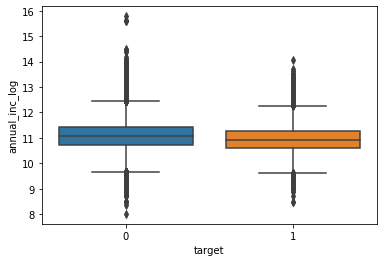

In [15]:
train['annual_inc_log'] = np.log(1 + train.annual_inc) # tạo thêm feature annual_inc_log cho tập train
test['annual_inc_log'] = np.log(1 + test.annual_inc) # tạo thêm feature annual_inc_log cho tập train

display(train.head())
sns.boxplot(train.target, train.annual_inc_log)

Biểu đồ cũng cho thấy phần lớn những khách hàng xấu thường có thu nhập thấp hơn (nhưng không đáng kể) so với khách hàng tốt.

## Categorical features.

Với các thuộc tính rời rạc, trước hết kiểm tra số lượng - tỉ lệ của mỗi giá trị. 

In [16]:
# đếm số lượng các giá trị biến grade - các loại hạng công việc và tỉ lệ
train.grade.value_counts() / len(train)

B    0.299000
C    0.258389
A    0.166029
D    0.161443
E    0.077130
F    0.030478
G    0.007531
Name: grade, dtype: float64

In [17]:
# đếm số lượng các giá trị emp_length - phân loại kinh nghiệm làm việc và tỉ lệ
train.emp_length.value_counts(dropna=False) / len(train)

10+ years    0.303198
2 years      0.092923
< 1 year     0.082953
3 years      0.080317
5 years      0.071027
1 year       0.067126
4 years      0.064389
6 years      0.058050
7 years      0.055622
8 years      0.047237
NaN          0.039414
9 years      0.037745
Name: emp_length, dtype: float64

Với các giá trị mising của **emp_length**, ta sẽ impute bằng giá trị mode (10+ years)

In [18]:
# chọn giá trị mode
mode_emp_length = '10+ years'
train.fillna(value=mode_emp_length, inplace=True)
# kiểm tra lại emp_length sau khi impute
train.emp_length.value_counts(dropna=False) / len(train)

10+ years    0.342612
2 years      0.092923
< 1 year     0.082953
3 years      0.080317
5 years      0.071027
1 year       0.067126
4 years      0.064389
6 years      0.058050
7 years      0.055622
8 years      0.047237
9 years      0.037745
Name: emp_length, dtype: float64

In [19]:
# đếm số lượng các giá trị biến home_ownership - các loại hình sợ hữu nhà và tỉ lệ
train.home_ownership.value_counts() / len(train)

MORTGAGE    0.494253
RENT        0.419006
OWN         0.086021
OTHER       0.000523
NONE        0.000191
ANY         0.000006
Name: home_ownership, dtype: float64

In [20]:
# đếm số loại thời hạn trả nợ
train.term.value_counts() / len(train)

 36 months    0.775157
 60 months    0.224843
Name: term, dtype: float64

## Feature Engineering

### 1. Feature Encoding

Trước khi training model, cần phải encode các categorical features.
Ta sẽ dùng kỹ thuật *One-hot encoding* để thực hiện encode.

In [21]:
# one-hot encoding of categorical variables
train = pd.get_dummies(train)
test = pd.get_dummies(test)
train

,loan_amnt,int_rate,annual_inc,target,annual_inc_log,grade_A,grade_B,grade_C,grade_D,grade_E,...,emp_length_9 years,emp_length_< 1 year,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,term_ 36 months,term_ 60 months
0,6000.0,9.76,33000.0,0,10.404293,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,19700.0,6.62,45000.0,0,10.714440,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,14000.0,6.03,75000.0,0,11.225257,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
3,21000.0,13.11,51000.0,0,10.839601,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,4500.0,16.29,96000.0,1,11.472114,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177928,4750.0,10.16,63000.0,0,11.050906,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
177929,10000.0,9.17,70600.0,0,11.164800,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
177930,9000.0,14.33,63000.0,0,11.050906,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
177931,19800.0,22.99,100000.0,0,11.512935,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [22]:
test

,loan_amnt,int_rate,annual_inc,target,annual_inc_log,grade_A,grade_B,grade_C,grade_D,grade_E,...,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,term_ 36 months,term_ 60 months
0,9525.0,6.62,60000.0,0,11.002117,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,17325.0,11.14,54000.0,1,10.896758,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,7000.0,8.49,118000.0,0,11.678448,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,10000.0,16.24,150000.0,0,11.918397,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,9600.0,12.12,120000.0,0,11.695255,0,1,0,0,0,...,1,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76252,9175.0,15.59,23000.0,0,10.043293,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
76253,6400.0,12.12,85000.0,0,11.350418,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
76254,25000.0,13.11,65000.0,0,11.082158,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
76255,5375.0,17.77,20000.0,0,9.903538,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0


Hot-encoding đã sinh ra các feature mới với giá trị 0 và 1 đại diện cho các giá trị trong **grade** và **home_ownership**.
Tuy nhiên, nếu trong tập test và tập train không đồng nhấ t về các giá trị, thì số cột mới sinh ra sẽ khác nhau ở hai tập dữ liệu. Ta sẽ kiểm tra điều này

In [23]:
print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (177933, 31)
Testing Features shape:  (76257, 30)


Tập train hiện có 30 cột, trong khi đó tập test chỉ có 29. Kiểm tra xem đâu là feature dẫn đến điều nayf:

In [24]:
print(set(train.columns) - set(test.columns))

{'home_ownership_ANY'}


In [25]:
b = list(test.columns)
b

['loan_amnt',
 'int_rate',
 'annual_inc',
 'target',
 'annual_inc_log',
 'grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'emp_length_1 year',
 'emp_length_10+ years',
 'emp_length_2 years',
 'emp_length_3 years',
 'emp_length_4 years',
 'emp_length_5 years',
 'emp_length_6 years',
 'emp_length_7 years',
 'emp_length_8 years',
 'emp_length_9 years',
 'emp_length_< 1 year',
 'home_ownership_MORTGAGE',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'term_ 36 months',
 'term_ 60 months']

Ta sẽ đồng bộ tập features giữa hai tập dữ liệu bằng cách loại bỏ đi những feature có trong train mà không có trong test.

In [26]:
# Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (177933, 30)
Testing Features shape:  (76257, 30)


Sau khi đồng bộ, tập train và test đều đã có 30 features.

### 2. Feature Construction

Sau khi encoding, ta sẽ tạo ra thêm các feature mới từ những domain feature có sẵn.
-    **loan_income_percentage**: tỉ lệ giữa khoản nợ và thu nhập hàng năm của người vay
-    **annual_interest**: lãi suất hàng năm
-    **ann_int_income_percentage**: tỉ lệ giữa lãi và thu nhập hàng năm của người vay
    

In [27]:
# generate new features for train data
train['loan_income_percentage'] = train['loan_amnt'] / train['annual_inc']
train['annual_interest'] = train['int_rate'] * train["loan_amnt"]
train['ann_int_income_percentage'] = train['annual_interest'] / train['annual_inc']

In [28]:
# generate new features for test data
test['loan_income_percentage'] = test['loan_amnt'] / test['annual_inc']
test['annual_interest'] = test['int_rate'] * test["loan_amnt"]
test['ann_int_income_percentage'] = test['annual_interest'] / test['annual_inc']

### 3. Data spliting

Chia tập train và test thành tập các features X và nhãn Y

In [29]:
# prepare train data
Y_train = train.target
X_train = train.drop(columns=['target'])

# prepare test data
Y_test = test['target']
X_test = test.drop(columns=['target'])


In [30]:
X_train.columns

Index(['loan_amnt', 'int_rate', 'annual_inc', 'annual_inc_log', 'grade_A',
       'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years',
       'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years',
       'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years',
       'emp_length_9 years', 'emp_length_< 1 year', 'home_ownership_MORTGAGE',
       'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'term_ 36 months', 'term_ 60 months',
       'loan_income_percentage', 'annual_interest',
       'ann_int_income_percentage'],
      dtype='object')

In [31]:
X_test.columns

Index(['loan_amnt', 'int_rate', 'annual_inc', 'annual_inc_log', 'grade_A',
       'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years',
       'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years',
       'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years',
       'emp_length_9 years', 'emp_length_< 1 year', 'home_ownership_MORTGAGE',
       'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'term_ 36 months', 'term_ 60 months',
       'loan_income_percentage', 'annual_interest',
       'ann_int_income_percentage'],
      dtype='object')

## Modeling bằng Random Forest

Sau khi đã hoàn thành encoding các feature, đồng bộ giữa hai tập dữ liệu train và test, ta sẽ sử dụng Random Forest để training.

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc


In [33]:
def evaluate(forest, X_train, Y_train, X_test, Y_test):
    forest.fit(X_train, Y_train)
    train_predictions = forest.predict_proba(X_train)[:,1]
    test_predictions = forest.predict_proba(X_test)[:,1]
    
    AUC_train = metrics.roc_auc_score(Y_train, train_predictions)
    AUC_test = metrics.roc_auc_score(Y_test, test_predictions)
    
    gini_train = 2 * AUC_train - 1
    gini_test = 2 * AUC_test - 1
    
#     print([gini_train, gini_test])
    return [gini_train, gini_test]

Tạo một random forest với tham số mặc định

In [34]:
random_forest = RandomForestClassifier()

In [35]:
# evaluating
evaluate(random_forest, X_train, Y_train, X_test, Y_test)

[0.9997329551170535, 0.302161607383999]

Model với bộ tham số mặc định cho kết quả gini đạt 0.996 với tập train và 0.3 với tập test.

## Model Tuning

Sau đây ta sẽ điều chỉnh các tham số của Random Forest để cải thiện hiệu suất của model.

**n_estimators**: Số cây trong forest. Thông thường, tăng số cây làm tăng hiệu suất của model nhưng cũng mất nhiều thời gian xử lý hơn.

Ở đây ta sẽ thử với số cây lần lượt bằng 1, 25, 50, 100, 250, 500.

Gini with n_estimators = 1: 
Train: 0.662 	 	 Test: 0.082
Gini with n_estimators = 25: 
Train: 0.999 	 	 Test: 0.275
Gini with n_estimators = 50: 
Train: 1.000 	 	 Test: 0.290
Gini with n_estimators = 100: 
Train: 1.000 	 	 Test: 0.300
Gini with n_estimators = 200: 
Train: 1.000 	 	 Test: 0.305
Gini with n_estimators = 400: 
Train: 1.000 	 	 Test: 0.308


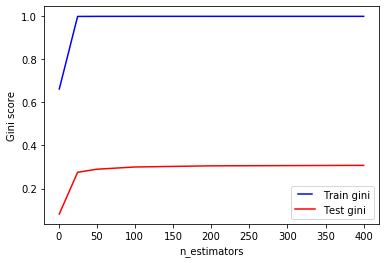

In [36]:
n_estimators = [1, 25, 50, 100, 200, 400]

train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1, random_state=42)
    
    print("Gini with n_estimators = %d: " % (estimator))
    print('Train: %.3f \t \t Test: %.3f' % (evaluate(rf, X_train, Y_train, X_test, Y_test)[0], evaluate(rf, X_train, Y_train, X_test, Y_test)[1] ))
    train_results.append(evaluate(rf, X_train, Y_train, X_test, Y_test)[0])
    test_results.append(evaluate(rf, X_train, Y_train, X_test, Y_test)[1])
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(n_estimators, train_results, 'b', label='Train gini')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test gini')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Gini score')
plt.xlabel('n_estimators')
plt.show()

Có thể thấy nếu chỉ dùng 1 cây, không còn ý nghĩa của "random forest" thì kết quả là rất thấp. Ngoài ra, model cho kết quả với tập train tốt hơn hẳn so với tập test. Và khi tăng số cây thì tăng chất lượng của model, nhưng khi đến mốc 25 cây thì sự cải thiện không còn đáng kể.

**max_depth**: độ sâu của mỗi cây trong forest.

Sau khi thử các giá trị của n_estimators, ta chọn số cây dùng cho model là 100 (số cây mặc định của random forest). Tiếp theo ta sẽ thử với max_depth chạy từ 1 đến 15.

Gini with max_depth = 1: 
Train: 0.361 	 	 Test: 0.358
Gini with max_depth = 2: 
Train: 0.377 	 	 Test: 0.374
Gini with max_depth = 3: 
Train: 0.385 	 	 Test: 0.382
Gini with max_depth = 4: 
Train: 0.391 	 	 Test: 0.387
Gini with max_depth = 5: 
Train: 0.396 	 	 Test: 0.391
Gini with max_depth = 6: 
Train: 0.402 	 	 Test: 0.393
Gini with max_depth = 7: 
Train: 0.409 	 	 Test: 0.394
Gini with max_depth = 8: 
Train: 0.421 	 	 Test: 0.396
Gini with max_depth = 9: 
Train: 0.438 	 	 Test: 0.396
Gini with max_depth = 10: 
Train: 0.462 	 	 Test: 0.396
Gini with max_depth = 11: 
Train: 0.495 	 	 Test: 0.397
Gini with max_depth = 12: 
Train: 0.539 	 	 Test: 0.395
Gini with max_depth = 13: 
Train: 0.590 	 	 Test: 0.393
Gini with max_depth = 14: 
Train: 0.649 	 	 Test: 0.392
Gini with max_depth = 15: 
Train: 0.719 	 	 Test: 0.386


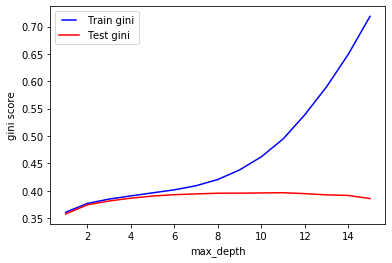

In [37]:
max_depths = np.linspace(1, 15, 15, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1, random_state=42)
    
    print("Gini with max_depth = %d: " % (max_depth))
    print('Train: %.3f \t \t Test: %.3f' % (evaluate(rf, X_train, Y_train, X_test, Y_test)[0], evaluate(rf, X_train, Y_train, X_test, Y_test)[1] ))
    
    train_results.append(evaluate(rf, X_train, Y_train, X_test, Y_test)[0])
    test_results.append(evaluate(rf, X_train, Y_train, X_test, Y_test)[1])
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, 'b', label='Train gini')
line2, = plt.plot(max_depths, test_results, 'r', label='Test gini')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('gini score')
plt.xlabel('max_depth')
plt.show()

Có thể thấy model bị overfit khi các cây có độ sâu lớn dần. Chọn max_depth bằng 11 sẽ cho hiệu suất tốt trên tập test.

**max_feature**: số feature được chọn cho mỗi cây.
Ở đây ta sẽ thử chọn lần lượt tăng dần số lương các feature.

Gini with max_features = 1: 
Train: 0.466 	 	 Test: 0.390
Gini with max_features = 5: 
Train: 0.495 	 	 Test: 0.397
Gini with max_features = 9: 
Train: 0.516 	 	 Test: 0.395
Gini with max_features = 13: 
Train: 0.524 	 	 Test: 0.394
Gini with max_features = 17: 
Train: 0.531 	 	 Test: 0.393
Gini with max_features = 21: 
Train: 0.532 	 	 Test: 0.394
Gini with max_features = 25: 
Train: 0.534 	 	 Test: 0.392
Gini with max_features = 29: 
Train: 0.536 	 	 Test: 0.392


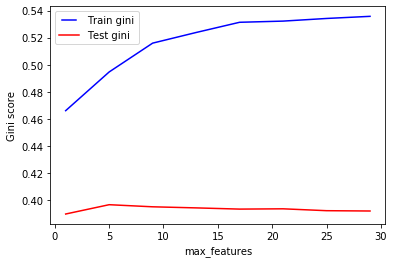

In [38]:
max_features = list(range(1, X_train.shape[1], 4))
train_results = []
test_results = []
for max_feature in max_features:
    rf = RandomForestClassifier(max_features=max_feature, n_jobs=-1, random_state=42, max_depth=11)
    
    print("Gini with max_features = %d: " % (max_feature))
    print('Train: %.3f \t \t Test: %.3f' % (evaluate(rf, X_train, Y_train, X_test, Y_test)[0], evaluate(rf, X_train, Y_train, X_test, Y_test)[1] ))
    
    train_results.append(evaluate(rf, X_train, Y_train, X_test, Y_test)[0])
    test_results.append(evaluate(rf, X_train, Y_train, X_test, Y_test)[1])

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_features, train_results, 'b', label='Train gini')
line2, = plt.plot(max_features, test_results, 'r', label='Test gini')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Gini score')
plt.xlabel('max_features')
plt.show()

Có thể nhận thấy việc thay đổi **max_features** không ảnh hưởng nhiều đến hiệu suất của model.

**min_samples_leaf**: số sample tối thiểu ở 1 nút lá.

Ta sẽ thử với các giá trị [10, 50, 100, 150, 250, 500]

Gini with min_samples_leaf = 10: 
Train: 0.466 	 	 Test: 0.397
Gini with min_samples_leaf = 50: 
Train: 0.439 	 	 Test: 0.397
Gini with min_samples_leaf = 100: 
Train: 0.427 	 	 Test: 0.397
Gini with min_samples_leaf = 150: 
Train: 0.421 	 	 Test: 0.397
Gini with min_samples_leaf = 250: 
Train: 0.414 	 	 Test: 0.396
Gini with min_samples_leaf = 500: 
Train: 0.406 	 	 Test: 0.396


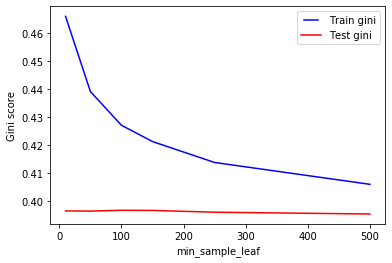

In [39]:
min_samples_leafs = [10, 50, 100, 150, 250, 500]
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, n_jobs=-1, random_state=42, max_depth=11)
    
    print("Gini with min_samples_leaf = %d: " % (min_samples_leaf))
    print('Train: %.3f \t \t Test: %.3f' % (evaluate(rf, X_train, Y_train, X_test, Y_test)[0], evaluate(rf, X_train, Y_train, X_test, Y_test)[1] ))
    
    train_results.append(evaluate(rf, X_train, Y_train, X_test, Y_test)[0])
    test_results.append(evaluate(rf, X_train, Y_train, X_test, Y_test)[1])
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train gini')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test gini')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Gini score')
plt.xlabel('min_sample_leaf')
plt.show()

Khi thay đổi **min_samples_leaf** không giúp cải thiện hiệu suất của model.

Sau khi thử điều chỉnh các tham số, ta sẽ tuning với các giá trị tốt nhất của **n_estimators** và **max_depth** dược chọn:
- n_estimator = 100
- max_depth = 11

In [40]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=11, n_jobs=-1)

In [41]:
print('Gini: ')
print('Train: %.3f \t \t Test: %.3f' % (evaluate(random_forest, X_train, Y_train, X_test, Y_test)[0], evaluate(rf, X_train, Y_train, X_test, Y_test)[1] ))


Gini: 
Train: 0.496 	 	 Test: 0.396


Với bộ tham số này, Random Forest đã không bị overfit, đồng thời cho kết quả khá tốt: gini đạt 0.396 với tập test.

### Feature importances

Trong nhiều trường hợp, một model tốt không chỉ yêu cầu độ chính xác cao mà còn cần phải dễ hiểu và dễ giải thích. Trong bài toán phân loại khách hàng tốt/xấu, việc chỉ ra yếu tố nào quyết định nhiều tới khả năng trả nợ cũng quan trọng không kém việc phân loại chính xác.

Ta sẽ thử kiểm tra mức độ quan trọng của các feature bằng feature_importances_ trong random forest.

In [42]:
feature_importance_values = random_forest.feature_importances_
features = X_train.columns
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

In [43]:
feature_importances.sort_values(by='importance', inplace=True, ignore_index=True)
feature_importances

,feature,importance
0,home_ownership_NONE,0.000208
1,home_ownership_OTHER,0.000590
2,grade_G,0.002439
3,emp_length_8 years,0.003096
4,emp_length_7 years,0.003188
5,emp_length_5 years,0.003190
6,emp_length_6 years,0.003263
7,emp_length_9 years,0.003483
8,emp_length_4 years,0.003536
9,emp_length_< 1 year,0.003580


Biểu diễn trên đồ thị

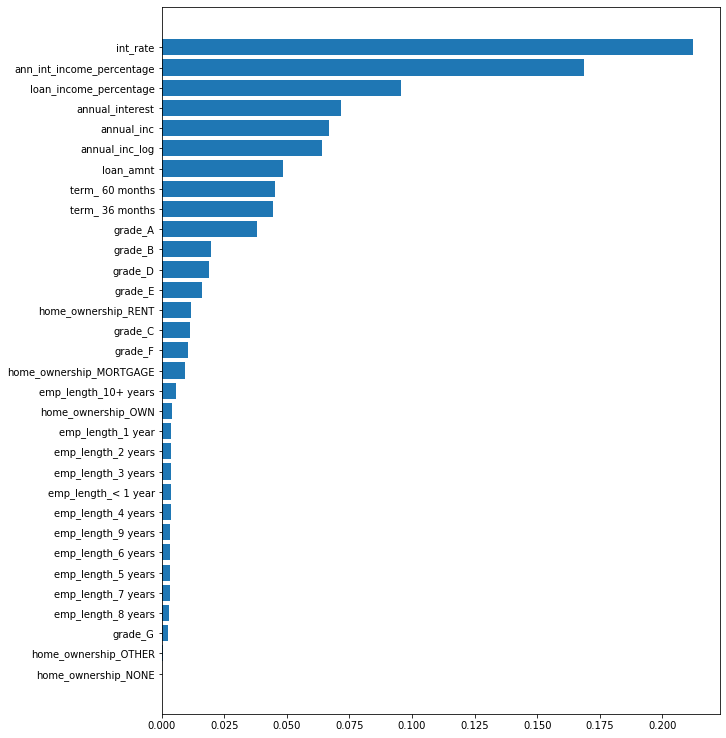

In [44]:
bars = tuple(feature_importances.feature)
importance = feature_importances.importance
y_pos = np.arange(len(bars))
f, ax = plt.subplots(figsize=(10,13))

plt.barh(y_pos, importance)
plt.yticks(y_pos, bars)
plt.show()

Tiếp theo, train model với số lượng feature được chọn tăng dần

Gini when using 1 feature(s): 
Train: 0.369 	 	 Test: 0.356
Gini when using 2 feature(s): 
Train: 0.465 	 	 Test: 0.376
Gini when using 3 feature(s): 
Train: 0.469 	 	 Test: 0.375
Gini when using 4 feature(s): 
Train: 0.509 	 	 Test: 0.386
Gini when using 5 feature(s): 
Train: 0.511 	 	 Test: 0.386
Gini when using 6 feature(s): 
Train: 0.507 	 	 Test: 0.386
Gini when using 7 feature(s): 
Train: 0.508 	 	 Test: 0.386
Gini when using 8 feature(s): 
Train: 0.508 	 	 Test: 0.392
Gini when using 9 feature(s): 
Train: 0.514 	 	 Test: 0.391
Gini when using 10 feature(s): 
Train: 0.508 	 	 Test: 0.392
Gini when using 11 feature(s): 
Train: 0.508 	 	 Test: 0.392
Gini when using 12 feature(s): 
Train: 0.504 	 	 Test: 0.393
Gini when using 13 feature(s): 
Train: 0.501 	 	 Test: 0.395
Gini when using 14 feature(s): 
Train: 0.503 	 	 Test: 0.395
Gini when using 15 feature(s): 
Train: 0.502 	 	 Test: 0.395
Gini when using 16 feature(s): 
Train: 0.508 	 	 Test: 0.396
Gini when using 17 feature(s): 
T

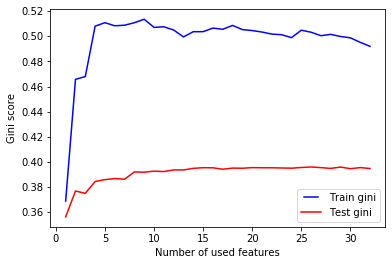

In [45]:
# sắp xếp lại các feature theo thứ tự độ quan trọng giảm dần
feature_importances.sort_values(by='importance', inplace=True, ignore_index=True, ascending=False)

train_results = []
test_results = []
for i in range(len(feature_importances)):
    X_train_important = X_train[feature_importances[0:i+1].feature]
    X_test_important = X_test[feature_importances[0:i+1].feature]
    print('Gini when using %d feature(s): ' % (i+1))
    print('Train: %.3f \t \t Test: %.3f' % (evaluate(random_forest, X_train_important, Y_train, X_test_important, Y_test)[0], evaluate(random_forest, X_train_important, Y_train, X_test_important, Y_test)[1] ))
    
    train_results.append(evaluate(random_forest, X_train_important, Y_train, X_test_important, Y_test)[0])
    test_results.append(evaluate(random_forest, X_train_important, Y_train, X_test_important, Y_test)[1])
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(range(1,len(feature_importances)+1), train_results, 'b', label='Train gini')
line2, = plt.plot(range(1,len(feature_importances)+1), test_results, 'r', label='Test gini')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Gini score')
plt.xlabel('Number of used features')
plt.show()

Có thể thấy chỉ cần sử dụng 16 feature đầu tiên đã đủ để model có hiệu suất tốt. Các feature còn lại không có nhiều ảnh hưởng đến target cũng như hiệu suất model. Vì vậy ta sẽ sử dụng 16 feature quan trọng để train cho model cuối cùng.

In [59]:
X_train_final = X_train[feature_importances[0:16].feature]
X_test_final = X_test[feature_importances[0:16].feature]
final_forest = RandomForestClassifier(n_estimators=100, max_depth=11)
final_forest.fit(X_train_final, Y_train)
Y_score = final_forest.predict_proba(X_test_final)[:,1]
final_gini = 2 * metrics.roc_auc_score(Y_test, Y_score) - 1
print('Final Gini: %.3f' %(final_gini))

Final Gini: 0.395


## Model Explanation

Sau khi xây dựng xong model, ta sẽ kiểm tra xem model có khả năng loại bỏ khách hàng xấu thực sự tốt hay không.
Kết quả dự đoán của model (Y_score) là xác suất để mỗi khách hàng là khách hàng xấu. 

In [60]:
Y_score

array([0.05196801, 0.14176525, 0.05745856, ..., 0.24927007, 0.30429993,
       0.09413068])

Chuẩn hóa Y_score về khoảng [0,1]

In [61]:
Y_copy = np.copy(Y_score)
for i in range(len(Y_score)):
    Y_score[i] = (Y_copy[i] - Y_copy.min()) / (Y_copy.max() - Y_copy.min())
Y_score

array([0.06474584, 0.19363556, 0.07262666, ..., 0.34794173, 0.42692839,
       0.12526368])

Để quyết định một khách hàng là tốt hay xấu, cần chọn một ngưỡng (threshold). Ví dụ với threshold = 0.5, những khách hàng có Y_score > 0.5 là khách hàng xấu và ngược lại. Ta sẽ kiểm tra xem khả năng phân loại của model với ngưỡng này như thế nào.

In [62]:
# số khách hàng dự đoán là xấu
pred = np.where(Y_score > 0.5, 1, 0)
pred_pos = pred.sum()
print('Predicted bad customers: ', pred_pos)

# số khách hàng xấu dự đoán đúng (tp)
tp = 0
for i in range(len(Y_test)):
    if Y_test[i] == 1 and pred[i] == 1:
        tp += 1
print('TP: ', tp)

# số khách hàng tốt bị dự đoán là xấu (fp)
fp = pred_pos - tp
print('FP: ', fp)

# số khách hàng xấu thực tế
actual_pos = Y_test.sum()
print('Actual bad customers: ', actual_pos)

#tỉ lệ loại được khách hàng xấu
print('True positive rate (Recall): ', tp/actual_pos)


Predicted bad customers:  6163
TP:  2619
FP:  3544
Actual bad customers:  13967
True positive rate (Recall):  0.18751342450060857


Model đã dự đoán có 6163 khách hàng xấu, trong đó chỉ có 2619 dự đoán là chính xác. Số khách hàng xấu trong thực tế là 13967, như vậy tỉ lệ loại được khách hàng xấu chỉ là 18,75%.

Nếu muốn loại bỏ được tỉ lệ lớn khách hàng xấu, ta cần giảm nguỡng quyết định xuống.
Ta sẽ kiểm tra lại với threshold = 0.1

In [63]:
pd.crosstab(Y_test, np.where(Y_score > 0.1, 1, 0), margins=True)

col_0,0,1,All
target,,,
0,9893,52397,62290
1,532,13435,13967
All,10425,65832,76257


Trong số 13967 khách hàng xấu trong thực tế, model đã có 13435 dự đoán đúng.
Tỉ lệ loại được khách hàng xấu là 13435/13976 = 96.13%.
Tuy nhiên để đạt được điều này, model cũng đã loại đi nhầm 52397 khách hàng tốt.
Số khách hàng có thể cho vay còn lại 10425, trong đó vẫn còn lẫn 532 khách hàng xấu, tỉ lệ là 532/10425 = 5.05%